# **NLP com Flair**
Este tutorial é baseado no livro "Natural Language Processing with Flair".

# 3 - Treinando Modelos

Vamos começar importando um corpus em português já taggeado. O corpus que vamos usar se chama [leNER-Br](https://huggingface.co/datasets/lener_br).

LeNER-Br é um dataset de NER (named entity recognition) composto de documentos legais anotados manualmente.
Ele contém as tags de lugar, tempo, organização, legisação e jurisprudência.
No total foram anotados 70 documentos jurídicos coletados de diferentes cortes brasileiras.

In [1]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus

/home/davibarreira/miniconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# define columns
columns = {0: 'text', 1: 'ner'}

# this is the folder in which train, test and dev files reside
data_folder = '/home/davibarreira/MEGA/resolvvi/lener-br/leNER-Br/'

# init a corpus using column format, data folder and the names of the train, dev and test files
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='train/train.conll',
                              test_file='test/test.conll',
                              dev_file='dev/dev.conll')

2022-10-19 14:00:28,311 Reading data from /home/davibarreira/MEGA/resolvvi/lener-br/leNER-Br
2022-10-19 14:00:28,317 Train: /home/davibarreira/MEGA/resolvvi/lener-br/leNER-Br/train/train.conll
2022-10-19 14:00:28,322 Dev: /home/davibarreira/MEGA/resolvvi/lener-br/leNER-Br/dev/dev.conll
2022-10-19 14:00:28,326 Test: /home/davibarreira/MEGA/resolvvi/lener-br/leNER-Br/test/test.conll


In [6]:
print(corpus)

Corpus: 7827 train + 1176 dev + 1389 test sentences


Vamos reduzir o tamanho do treino, já que só queremos explorar como funciona o Flair. 

In [7]:
import random
random.seed(123)  # ensure we get same split every time
corpus.downsample(0.01)
print(corpus)

Corpus: 78 train + 12 dev + 14 test sentences


## Dicionário de Tags

Com nosso corpus em mãos, vamos ver quais são as tags presentes.

In [9]:
tag_type = 'ner'
tag_dictionary = corpus.make_label_dictionary(tag_type)

2022-10-19 14:00:45,538 Computing label dictionary. Progress:


78it [00:00, 13317.42it/s]

2022-10-19 14:00:45,551 Dictionary created for label 'ner' with 7 values: ORGANIZACAO (seen 36 times), JURISPRUDENCIA (seen 19 times), PESSOA (seen 15 times), TEMPO (seen 14 times), LEGISLACAO (seen 12 times), LOCAL (seen 2 times)


In [10]:
print(tag_dictionary)

Dictionary with 7 tags: <unk>, ORGANIZACAO, JURISPRUDENCIA, PESSOA, TEMPO, LEGISLACAO, LOCAL


Assim como na introdução, temos nossas 6 tags (organização, legislação,...) e uma sétima tag chamada `<unk>` que simboliza
*unknown*.

## Definindo nosso embedding

Vamos usar o stacked embedding com o embedding por palavra e o FlairEmbedding
ambos forward a backward.

In [11]:
from flair.embeddings import (WordEmbeddings,
                              StackedEmbeddings,
                              FlairEmbeddings)

embedding_types = [
    WordEmbeddings('pt'),
    FlairEmbeddings('pt-forward'),
    FlairEmbeddings('pt-backward'),
]
embeddings = StackedEmbeddings(embeddings=embedding_types)

## Criando nosso modelo

O nosso SequenceTagger é uma Recurrent Neural Network com 256 hidden layers.
Vamos inicializar nosso modelo. Isso irá atribuir pesos aleatórios à cada neurônio.

In [12]:
from flair.models import SequenceTagger
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type=tag_type)

2022-10-19 14:00:54,817 SequenceTagger predicts: Dictionary with 25 tags: O, S-ORGANIZACAO, B-ORGANIZACAO, E-ORGANIZACAO, I-ORGANIZACAO, S-JURISPRUDENCIA, B-JURISPRUDENCIA, E-JURISPRUDENCIA, I-JURISPRUDENCIA, S-PESSOA, B-PESSOA, E-PESSOA, I-PESSOA, S-TEMPO, B-TEMPO, E-TEMPO, I-TEMPO, S-LEGISLACAO, B-LEGISLACAO, E-LEGISLACAO, I-LEGISLACAO, S-LOCAL, B-LOCAL, E-LOCAL, I-LOCAL


Nosso modelo já funciona, porém, preicsaremos treiná-lo para de fato obtermos previsões boas. 
Antes de treinar, vamos mostrar que de fato ele já gera resultados.

In [13]:
from flair.data import Sentence
sentence = Sentence('Certificar o trânsito em julgado da sentença.')
tagger.predict(sentence)
print(sentence)

Sentence: "Certificar o trânsito em julgado da sentença ." → ["Certificar o"/PESSOA, "trânsito em julgado"/PESSOA, "da"/ORGANIZACAO, "sentença"/TEMPO, "."/ORGANIZACAO]


## Treinando

O processo de treinamento envolve criar um objeto do tipo `ModelTrainer` e depois
usar o método `train()`.

Vamos começar criando nosso ModelTrainer.

In [14]:
from flair.trainers import ModelTrainer
trainer = ModelTrainer(tagger, corpus)

O que resta agoar é treinar. Aqui existem uma série de parâmetro diferentes que podemos passar na hora de treinar. 
Alguns deles são:

* `base_path`: Caminho onde será salvo o modelo treinado;
* `learning_rate`: Padrão é 0.1;
* `mini_batch_size`: Tamanho do batch de treinamento, com padrão de 32;
* `max_epochs`: Número máximo de épocas de treinamento;
* `patience`: Número mínimo de épocas sem melhoria do modelo (padrão 3);
* `epoch`: A época atual caso tenha parado o treinamento e queira retormar;
* `optimizer`: Modelo de otimização. Por padrão usa o stochastic gradient descent do Pytorch;
* `train_with_dev`: Se vai usar o set dev de validação para treinar o modelo;
* `checkpoint`: Se `True`, salva um checkpoint do modelo a cada época de treinamento;
* `write_weights`: Se `True`, os pesos serão salvos num arquivo `weights.txt`.

In [15]:
trainer.train('./models/tagger',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150,
              train_with_dev=True)

2022-10-19 14:00:58,339 ----------------------------------------------------------------------------------------------------
2022-10-19 14:00:58,343 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'pt'
      (embedding): Embedding(592108, 300)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(275, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=275, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(275, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=275, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4396, out_features=4396, bias=T

100%|███████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]

2022-10-19 14:12:17,928 Evaluating as a multi-label problem: False
2022-10-19 14:12:17,945 0.4091	0.45	0.4286	0.2903
2022-10-19 14:12:17,946 
Results:
- F-score (micro) 0.4286
- F-score (macro) 0.4034
- Accuracy 0.2903

By class:
                precision    recall  f1-score   support

   ORGANIZACAO     0.4000    0.5714    0.4706         7
    LEGISLACAO     0.2500    0.2500    0.2500         4
         TEMPO     1.0000    0.2500    0.4000         4
        PESSOA     1.0000    0.6667    0.8000         3
JURISPRUDENCIA     0.3333    1.0000    0.5000         1
         LOCAL     0.0000    0.0000    0.0000         1

     micro avg     0.4091    0.4500    0.4286        20
     macro avg     0.4972    0.4563    0.4034        20
  weighted avg     0.5567    0.4500    0.4397        20

2022-10-19 14:12:17,947 ----------------------------------------------------------------------------------------------------


{'test_score': 0.4285714285714286,
 'dev_score_history': [],
 'train_loss_history': [2.994354027225036,
  1.017944512594971,
  0.8535696821861433,
  0.7843554616837012,
  0.7550920632744663,
  0.6447654978066208,
  0.651028888442927,
  0.6063619301736614,
  0.5872485634214454,
  0.5597421118906024,
  0.5055422748394537,
  0.5662702237472865,
  0.490506780820369,
  0.46176549356684155,
  0.439878692847775,
  0.44644416775958756,
  0.41438560651456224,
  0.3817182836242764,
  0.40597565094744936,
  0.4030310358911451,
  0.3526072522838278,
  0.3263432327469247,
  0.3251698738241679,
  0.2681066841534009,
  0.27310803381647974,
  0.28155879725940663,
  0.24995989875407018,
  0.2273390862427641,
  0.24825427087102026,
  0.2179875463549204,
  0.19379430569374095,
  0.17935361737970332,
  0.15493743499005064,
  0.16979715482543414,
  0.14667233854920406,
  0.17368962554269174,
  0.1743764697901592,
  0.13886072183655934,
  0.12769473306349494,
  0.13217829967890737,
  0.1414648296174023,
  0

Após finalizado o treinamento, uma série de arquivos foram salvos na pasta que passamos como raíz.
Vamos importar o modelo e ver o resultado.

In [17]:
tagger = SequenceTagger.load('./models/tagger/final-model.pt')

2022-10-19 15:05:24,271 loading file ./models/tagger/final-model.pt
2022-10-19 15:05:26,535 SequenceTagger predicts: Dictionary with 27 tags: O, S-ORGANIZACAO, B-ORGANIZACAO, E-ORGANIZACAO, I-ORGANIZACAO, S-JURISPRUDENCIA, B-JURISPRUDENCIA, E-JURISPRUDENCIA, I-JURISPRUDENCIA, S-PESSOA, B-PESSOA, E-PESSOA, I-PESSOA, S-TEMPO, B-TEMPO, E-TEMPO, I-TEMPO, S-LEGISLACAO, B-LEGISLACAO, E-LEGISLACAO, I-LEGISLACAO, S-LOCAL, B-LOCAL, E-LOCAL, I-LOCAL, <START>, <STOP>


In [35]:
sentenca = Sentence(corpus.test[0].text)
tagger.predict(sentenca)
print(sentenca)
print('-----')
print(corpus.test[0])

Sentence: "A possibilidade de devolução dos recursos ao Tesouro Nacional não constitui justificativa hábil a ensejar pagamentos antecipados temerários , sem sequer se acercar da lisura dos documentos apresentados pelo Grupo OK ." → ["Tesouro Nacional"/ORGANIZACAO]
-----
Sentence: "A possibilidade de devolução dos recursos ao Tesouro Nacional não constitui justificativa hábil a ensejar pagamentos antecipados temerários , sem sequer se acercar da lisura dos documentos apresentados pelo Grupo OK ." → ["Tesouro Nacional"/ORGANIZACAO/ORGANIZACAO, "Nacional"/I-ORGANIZACAO/I-ORGANIZACAO, "OK"/I-ORGANIZACAO/O]



----
No exemplo acima, nosso modelo capturou parte do tag correto, mas não todo.

## Avaliando o modelo e o treinamento

Finalmente, vamo verificar o resultado do nosso modelo. Usamos o método `evaluate`
para obter os valores de eficiência do modelo (precisão, f1, etc) no nosso dataset de teste.

In [63]:
import pandas as pd
result = tagger.evaluate(corpus.test,gold_label_type="ner")
result = pd.DataFrame(result.classification_report)

100%|███████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]

2022-10-19 15:23:10,666 Evaluating as a multi-label problem: False


In [64]:
result

,ORGANIZACAO,LEGISLACAO,TEMPO,PESSOA,JURISPRUDENCIA,LOCAL,micro avg,macro avg,weighted avg
precision,0.400000,0.25,1.00,1.000000,0.333333,0.0,0.409091,0.497222,0.564912
recall,0.666667,0.25,0.25,0.666667,1.000000,0.0,0.473684,0.472222,0.473684
f1-score,0.500000,0.25,0.40,0.800000,0.500000,0.0,0.439024,0.408333,0.447368
support,6.000000,4.00,4.00,3.000000,1.000000,1.0,19.000000,19.000000,19.000000


Podemos também ver como foi a curva de perda do modelo para verificar se mais treinamento ajudaria a melhorar o modelo.
No gráfico abaixo, fica claro que treinar em mais épocas não ajudaria.

2022-10-19 15:22:08,583 ----------------------------------------------------------------------------------------------------
2022-10-19 15:22:08,584 WARNING: No LOSS found for test split in this data.
2022-10-19 15:22:08,585 Are you sure you want to plot LOSS and not another value?
2022-10-19 15:22:08,585 ----------------------------------------------------------------------------------------------------
2022-10-19 15:22:09,419 Loss and F1 plots are saved in models/tagger/training.png


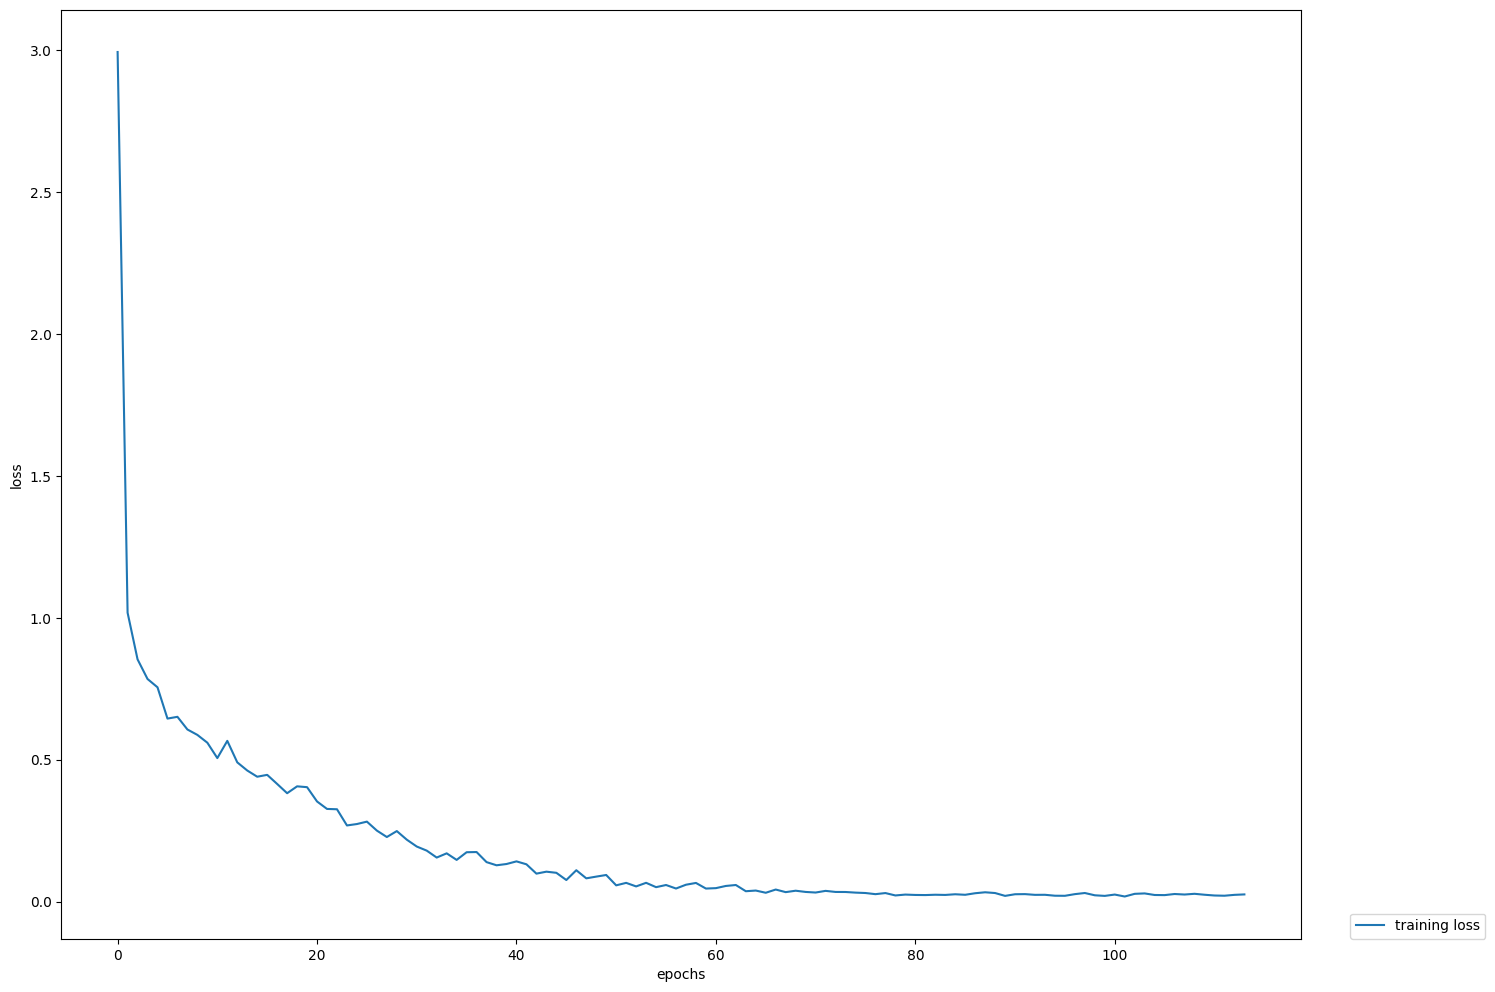

In [62]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('./models/tagger/loss.tsv',['loss'])